In [263]:
!pip install statsmodels

In [264]:
pip install pykalman

In [265]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

In [266]:
df = pd.read_csv('sensor_data.csv')

In [267]:
df.head()

,_id,flowmeter_1,flowmeter_2,pressure_3,flowmeter_4,flowmeter_5,flowmeter_6,flowmeter_7
0,2025-03-01 00:00:00,29.154518,2.381213,557.779602,1.789499,8.024493,3.090302,2.3148
1,2025-03-01 00:10:00,28.985508,2.406482,557.497742,1.815873,8.044760,3.109822,2.3328
2,2025-03-01 00:20:00,29.180040,2.427540,556.837219,1.840293,7.965942,3.128422,2.3512
3,2025-03-01 00:30:00,29.205606,2.445229,557.021484,1.864713,7.925407,3.144000,2.3676
4,2025-03-01 00:40:00,29.325514,2.465444,558.429871,1.890110,7.898383,3.161402,2.3856


In [268]:
df.describe()

,flowmeter_1,flowmeter_2,pressure_3,flowmeter_4,flowmeter_5,flowmeter_6,flowmeter_7
count,13236.000000,13247.000000,13248.000000,13247.000000,13239.000000,13248.000000,13247.000000
mean,21.352763,2.182232,507.935042,1.829418,5.264428,3.307234,2.657986
std,8.434696,0.391975,24.030270,0.141272,3.395918,0.262880,0.267827
min,0.000000,1.309793,0.000000,1.353846,-0.294212,2.590520,1.976400
25%,16.458197,1.836238,490.880005,1.725031,0.000000,3.097794,2.427999
50%,19.413706,2.117569,500.000000,1.837363,7.164248,3.341402,2.700614
75%,30.978935,2.405219,536.320007,1.943834,7.533567,3.509083,2.868400
max,40.551502,2.910184,559.679871,2.095238,15.163173,3.908099,3.202000


In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13248 entries, 0 to 13247
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          13248 non-null  object 
 1   flowmeter_1  13236 non-null  float64
 2   flowmeter_2  13247 non-null  float64
 3   pressure_3   13248 non-null  float64
 4   flowmeter_4  13247 non-null  float64
 5   flowmeter_5  13239 non-null  float64
 6   flowmeter_6  13248 non-null  float64
 7   flowmeter_7  13247 non-null  float64
dtypes: float64(7), object(1)
memory usage: 828.1+ KB


In [270]:
# Number of NaNs per column
null_counts = df.isna().sum()

# Combine both into a single DataFrame
summary = pd.DataFrame({
    'Null Values': null_counts
})

In [271]:
print(summary)

             Null Values
_id                    0
flowmeter_1           12
flowmeter_2            1
pressure_3             0
flowmeter_4            1
flowmeter_5            9
flowmeter_6            0
flowmeter_7            1


In [272]:
# Convert the '_id' column to datetime format
df['_id'] = pd.to_datetime(df['_id'])

# Set '_id' as the index
df.set_index('_id', inplace=True)

# Optional: sort the DataFrame by datetime index (recommended for time series)
df.sort_index(inplace=True)


In [239]:
cols = ['flowmeter_2', 'flowmeter_4','flowmeter_5', 'flowmeter_7']

for col in cols:
    vals = df[col].values
    vals_masked = np.ma.masked_invalid(vals)

    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=np.nanmean(vals),
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.01
    )
    kf = kf.em(vals_masked, n_iter=5)
    smoothed_state_means, _ = kf.smooth(vals_masked)
    kalman_1d = smoothed_state_means.flatten()

    # Copy original values
    filled = vals.copy()
    nan_mask = np.isnan(vals)
    filled[nan_mask] = kalman_1d[nan_mask]

    # Assign imputed values to a new column
    df[f'{col}_imputed'] = filled


In [240]:
# Ensure your DataFrame has 'flowmeter_1' and 'pressure'
obs = df[['flowmeter_1', 'pressure_3']].values
# Mask missing values (pykalman handles these naturally)
obs_masked = np.ma.masked_invalid(obs)


In [241]:

kf = KalmanFilter(
    n_dim_obs=2,
    n_dim_state=2,
    initial_state_mean=np.nanmean(obs, axis=0),
    initial_state_covariance=np.eye(2),
    transition_matrices=np.eye(2),           # Adjust if you have a process model
    observation_matrices=np.eye(2),
    observation_covariance=np.eye(2),        # Estimate or set based on data
    transition_covariance=0.01 * np.eye(2)   # Small process noise
)


In [242]:
# Fit parameters using Expectation-Maximization (EM), helpful with missing data
kf = kf.em(obs_masked, n_iter=10)

# Apply smoothing to estimate all positions, including missing values
state_means, _ = kf.smooth(obs_masked)


In [243]:
imputed = df['flowmeter_1'].copy()
missing_mask = df['flowmeter_1'].isna()
imputed[missing_mask] = state_means[missing_mask, 0]  # 0th column corresponds to flowmeter_1

df['flowmeter_1_imputed'] = imputed


In [244]:
# Create mask flags: True if original was NaN (i.e., imputed)
df['flowmeter_1_missing_flag'] = df['flowmeter_1'].isna()
df['flowmeter_5_missing_flag'] = df['flowmeter_5'].isna()

In [245]:
# This will select only columns with no nulls (completely filled columns)
df_updated = df.loc[:, df.notnull().all()]

# The DateTimeIndex (your time index) remains unchanged,
# and you'll keep only the columns where ALL values are non-null

print(df_updated.shape)


(13248, 9)


In [246]:
# Step 2: Compute correlation matrix
corr_matrix = df_updated.corr()

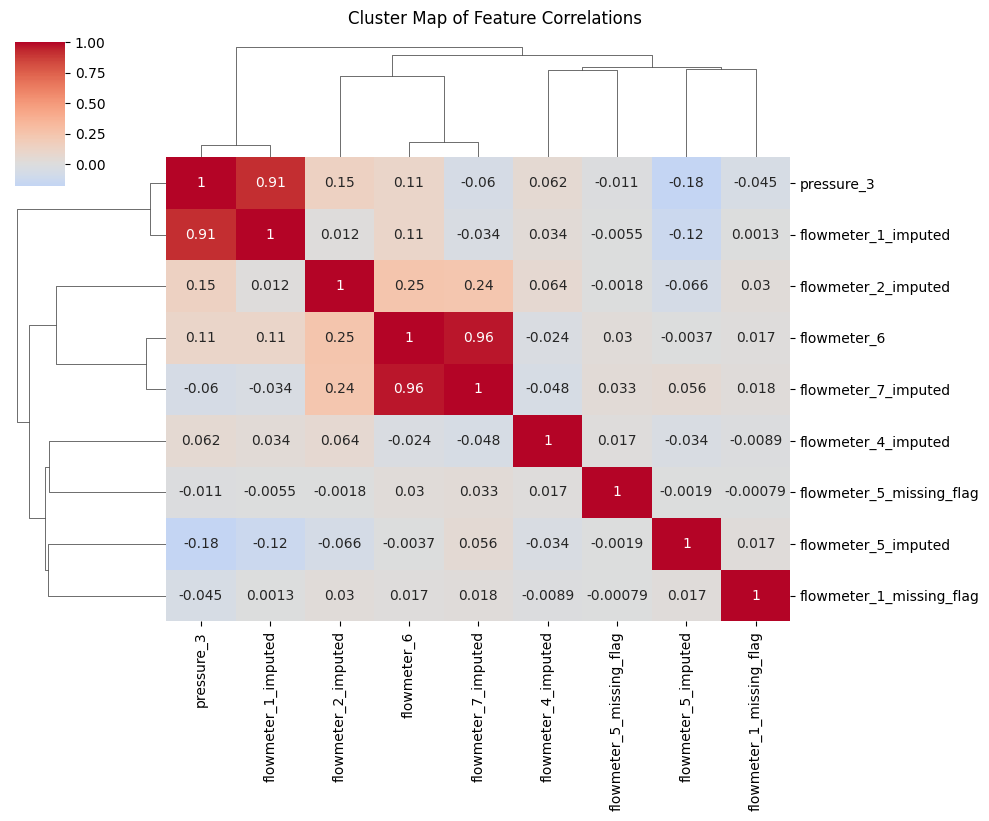

In [247]:
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', figsize=(10, 8), center=0)
plt.suptitle("Cluster Map of Feature Correlations", y=1.02)
plt.show()


In [248]:
# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_updated)

In [249]:
feature_names = df_updated.columns

In [250]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

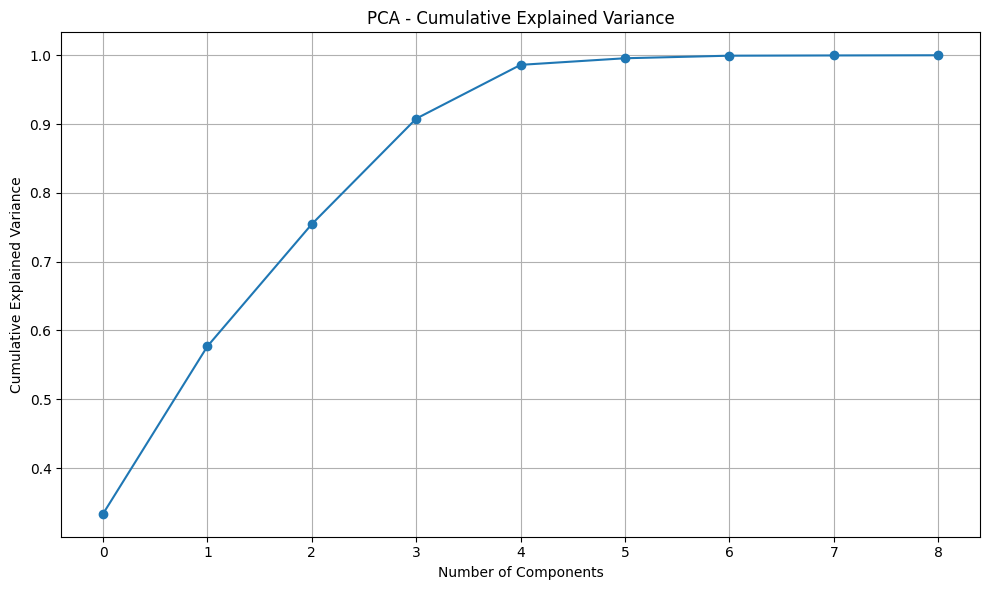

In [251]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [252]:
# Make a DataFrame of PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(df_updated.columns))], index=feature_names)

# Top contributing features to PC1 and PC2
print(loadings[['PC1', 'PC2']].sort_values(by='PC1', ascending=False))


                               PC1       PC2
flowmeter_6               0.663786 -0.093102
flowmeter_7_imputed       0.615019 -0.211470
flowmeter_2_imputed       0.394149  0.103479
pressure_3                0.116132  0.641072
flowmeter_1_imputed       0.110008  0.691072
flowmeter_5_missing_flag  0.000726 -0.000433
flowmeter_1_missing_flag  0.000693 -0.000883
flowmeter_4_imputed      -0.006662  0.167477
flowmeter_5_imputed      -0.012352 -0.138931


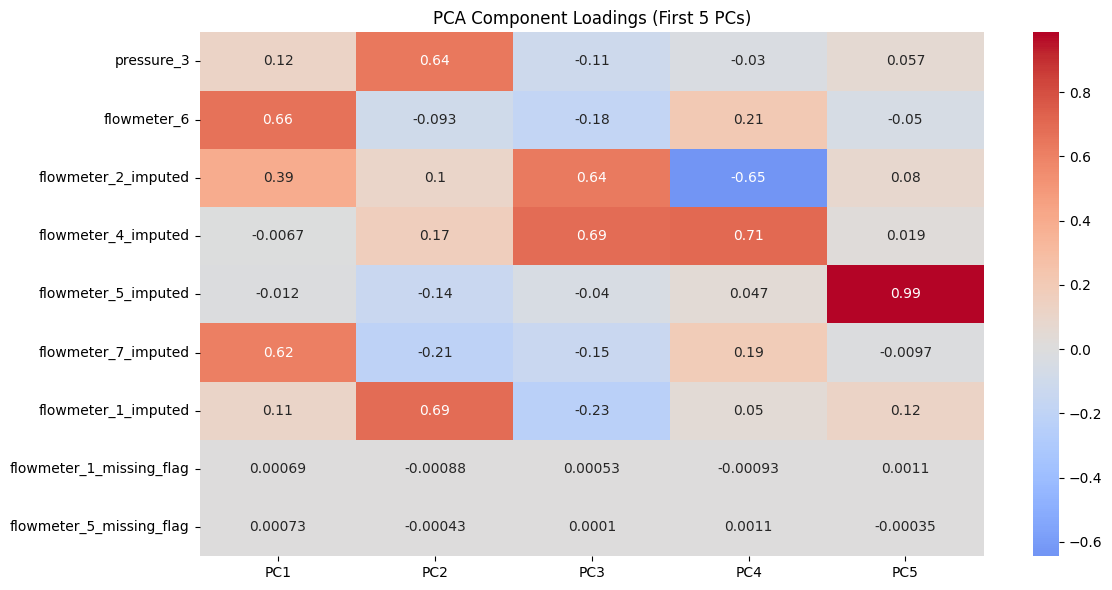

In [253]:
plt.figure(figsize=(12, 6))
sns.heatmap(loadings.iloc[:, :5], cmap='coolwarm', center=0, annot=True)
plt.title("PCA Component Loadings (First 5 PCs)")
plt.tight_layout()
plt.show()


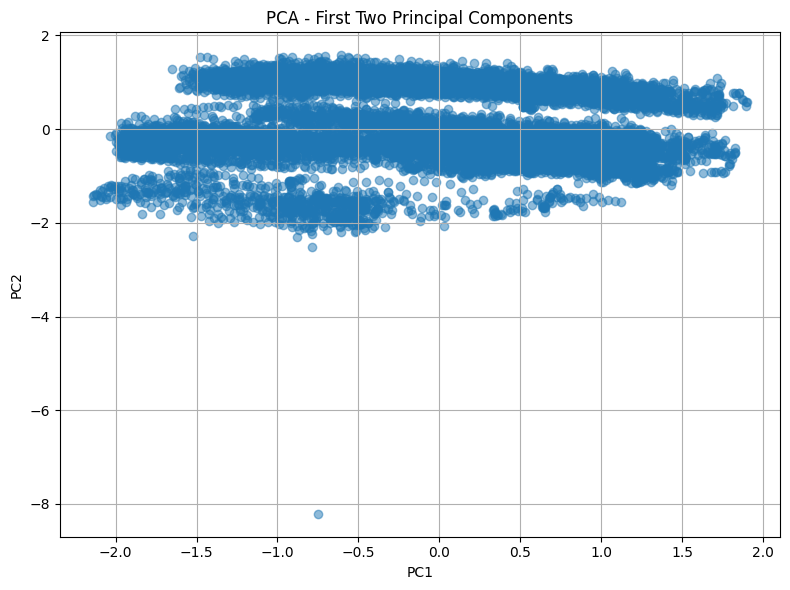

In [254]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - First Two Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()


In [255]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2025-03-01 00:00:00 to 2025-05-31 23:50:00
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pressure_3                13248 non-null  float64
 1   flowmeter_6               13248 non-null  float64
 2   flowmeter_2_imputed       13248 non-null  float64
 3   flowmeter_4_imputed       13248 non-null  float64
 4   flowmeter_5_imputed       13248 non-null  float64
 5   flowmeter_7_imputed       13248 non-null  float64
 6   flowmeter_1_imputed       13248 non-null  float64
 7   flowmeter_1_missing_flag  13248 non-null  bool   
 8   flowmeter_5_missing_flag  13248 non-null  bool   
dtypes: bool(2), float64(7)
memory usage: 853.9 KB


In [258]:
df_updated = df_updated.drop(columns= ['flowmeter_1_missing_flag','flowmeter_5_missing_flag'])

In [259]:
from statsmodels.tsa.stattools import adfuller
# Define a function to perform the Augmented Dickey-Fuller (ADF) test for stationarity
def check_stationarity(series, significance_level=0.05):
    """
    Perform ADF test and return True if series is stationary (p-value <= significance_level),
    else False indicating non-stationarity.
    """
    # Skip constant series (should not be present if removed already)
    if series.max() == series.min():
        print(f"Skipping series '{series.name}' because it is constant.")
        return True  # Consider constant series as stationary to avoid differencing

    result = adfuller(series, autolag='AIC')
    p_value = result[1]

    if p_value <= significance_level:
        print(f"Series '{series.name}' is stationary (p={p_value:.4f})")
        return True
    else:
        print(f"Series '{series.name}' is non-stationary (p={p_value:.4f})")
        return False

# Apply stationarity test and difference non-stationary columns
for col in df_updated.columns:
    is_stationary = check_stationarity(df_updated[col])
    if not is_stationary:
        # Apply first-order differencing to make stationary
        print(f"Differencing column '{col}' to achieve stationarity.")
        df_updated[col] = df_updated[col].diff()

# Differencing creates NaN values in the first row for differenced columns
# Drop rows with any NaNs created by differencing
data_stationary = df_updated.dropna()

print("\nData after differencing non-stationary columns:")
print(data_stationary.head())

Series 'pressure_3' is stationary (p=0.0000)
Series 'flowmeter_6' is stationary (p=0.0000)
Series 'flowmeter_2_imputed' is stationary (p=0.0000)
Series 'flowmeter_4_imputed' is stationary (p=0.0000)
Series 'flowmeter_5_imputed' is stationary (p=0.0000)
Series 'flowmeter_7_imputed' is stationary (p=0.0000)
Series 'flowmeter_1_imputed' is stationary (p=0.0000)

Data after differencing non-stationary columns:
                     pressure_3  flowmeter_6  flowmeter_2_imputed  \
_id                                                                 
2025-03-01 00:00:00  557.779602     3.090302             2.381213   
2025-03-01 00:10:00  557.497742     3.109822             2.406482   
2025-03-01 00:20:00  556.837219     3.128422             2.427540   
2025-03-01 00:30:00  557.021484     3.144000             2.445229   
2025-03-01 00:40:00  558.429871     3.161402             2.465444   

                     flowmeter_4_imputed  flowmeter_5_imputed  \
_id                                      

In [260]:
from statsmodels.tsa.api import VAR

# Assume 'data_stationary' contains your stationary time series features (like those you checked)
# Since all are stationary, data_stationary = original cleaned data (no differencing needed)

# Fit the VAR model
model_b = VAR(data_stationary)

# Select lag order (you can adjust maxlags based on your data)
lag_order_results = model_b.select_order(maxlags=1)
print(lag_order_results.summary())

selected_lag = lag_order_results.aic  # or choose bic or hqic
print(f"Selected lag order (AIC): {selected_lag}")

# Fit the model with selected lag order
var_result = model_b.fit(selected_lag)

# Forecast next 5 steps as an example
forecast_steps = 1
forecast = var_result.forecast(y=data_stationary.values[-selected_lag:], steps=forecast_steps)

forecast_df = pd.DataFrame(forecast, columns=data_stationary.columns)
print("Forecasted values:")
print(forecast_df)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -3.077      -3.073     0.04609      -3.076
1     -33.04*     -33.01*  4.463e-15*     -33.03*
-------------------------------------------------
Selected lag order (AIC): 1
Forecasted values:
   pressure_3  flowmeter_6  flowmeter_2_imputed  flowmeter_4_imputed  \
0   533.13349     2.970784              1.84568             1.911073   

   flowmeter_5_imputed  flowmeter_7_imputed  flowmeter_1_imputed  
0             7.072914             2.273285            31.519676  


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


In [261]:
# 'var_result' is your trained VAR model (fit object)
# 'data_stationary' is your stationary DataFrame used to fit the VAR

# Step 1: Get the fitted values (one-step-ahead predictions in-sample)
predicted_b = var_result.fittedvalues

# Step 2: Align actual data with predictions (predictions exclude initial lags)
actual = data_stationary.loc[predicted_b.index]

# Step 3: Calculate residuals (actual - predicted)
residuals = actual - predicted_b

# Step 4: Set anomaly detection threshold (e.g., 3 standard deviations)
anomaly_flags = pd.DataFrame(False, index=residuals.index, columns=residuals.columns)

for col in residuals.columns:
    resid_std = residuals[col].std()
    threshold = 3 * resid_std
    anomaly_flags[col] = residuals[col].abs() > threshold

# Initialize an empty set to hold unique anomaly timestamps
anomaly_timestamps = set()

# Iterate over each feature/column to find anomalies and collect their timestamps
for col in residuals.columns:
    # Get all anomaly residuals for this column
    anomalies = residuals[anomaly_flags[col]][col]
    if not anomalies.empty:
        # Add the anomaly timestamps (index values) to the set
        anomaly_timestamps.update(anomalies.index)

# Return sorted list of all unique anomaly timestamps
anomaly_timestamps_list = sorted(anomaly_timestamps)

print(anomaly_timestamps_list)

# You can also examine residuals visually or analyze their distribution


[Timestamp('2025-03-01 01:40:00'), Timestamp('2025-03-01 02:10:00'), Timestamp('2025-03-01 04:40:00'), Timestamp('2025-03-01 06:50:00'), Timestamp('2025-03-01 08:30:00'), Timestamp('2025-03-01 16:50:00'), Timestamp('2025-03-01 17:20:00'), Timestamp('2025-03-01 18:50:00'), Timestamp('2025-03-01 19:00:00'), Timestamp('2025-03-01 21:40:00'), Timestamp('2025-03-01 23:10:00'), Timestamp('2025-03-01 23:20:00'), Timestamp('2025-03-02 01:40:00'), Timestamp('2025-03-02 02:00:00'), Timestamp('2025-03-02 04:00:00'), Timestamp('2025-03-02 06:50:00'), Timestamp('2025-03-02 15:00:00'), Timestamp('2025-03-02 15:20:00'), Timestamp('2025-03-02 16:40:00'), Timestamp('2025-03-02 17:00:00'), Timestamp('2025-03-02 20:40:00'), Timestamp('2025-03-02 22:30:00'), Timestamp('2025-03-02 23:10:00'), Timestamp('2025-03-02 23:20:00'), Timestamp('2025-03-03 00:50:00'), Timestamp('2025-03-03 02:20:00'), Timestamp('2025-03-03 03:00:00'), Timestamp('2025-03-03 06:00:00'), Timestamp('2025-03-03 07:00:00'), Timestamp('20

In [262]:
len(anomaly_timestamps_list)

1511